
# Lab 1: model-agnostic methods (PDP and ICE)

In this laboratory we will use model agnostic methods to quantify the effect of each variable on the output of a GradientBoosting model. The goal is to learn how to correctly use these methods and analyze the results. We will not implement these methods from scratch, instead relying on the implementation available from the ```sklearn``` package.



## Dataset preprocessing

As an example we will use a bike sharing dataset. Data is composed of hourly number of bike rentals and meteorological and datetime information. The goal is to predict the number of bike rentals in one hour. 



In [9]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target

# We use only a subset of the data to speed up the example.
X = X.iloc[::4, :]
y = y[::4]

c:\Users\franc\Anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


First, we have a look at the dataset

In [10]:
X.head(20)

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000
8,spring,0,1,8,False,6,False,clear,9.84,14.395,0.75,0.0000
12,spring,0,1,12,False,6,False,clear,17.22,21.210,0.77,19.0012
16,spring,0,1,16,False,6,False,misty,17.22,21.210,0.82,19.9995
20,spring,0,1,20,False,6,False,misty,16.40,20.455,0.87,16.9979
24,spring,0,1,0,False,0,False,misty,18.86,22.725,0.88,19.9995
28,spring,0,1,4,False,0,False,misty,18.86,22.725,0.94,12.9980
32,spring,0,1,9,False,0,False,misty,15.58,19.695,0.76,15.0013
36,spring,0,1,13,False,0,False,misty,14.76,17.425,0.66,8.9981


We now have a closer look at the `"year"` feature:



In [11]:
X["year"].value_counts()

1    2183
0    2162
Name: year, dtype: int64

We see that we have data from two years. We use the first year to train the
model and the second year to test the model.



In [12]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

We can check the dataset information to see that we have heterogeneous data types. We
have to preprocess the different columns accordingly.



In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2162 entries, 0 to 8644
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      2162 non-null   category
 1   month       2162 non-null   int64   
 2   hour        2162 non-null   int64   
 3   holiday     2162 non-null   category
 4   weekday     2162 non-null   int64   
 5   workingday  2162 non-null   category
 6   weather     2162 non-null   category
 7   temp        2162 non-null   float64 
 8   feel_temp   2162 non-null   float64 
 9   humidity    2162 non-null   float64 
 10  windspeed   2162 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 144.2 KB


From the previous information, we will consider the `category` columns as nominal
categorical features. In addition, we will consider the date and time information as
categorical features as well.

We manually define the columns containing numerical and categorical
features.



In [14]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

We plot the average number of bike rentals by grouping the data by season and
by year.



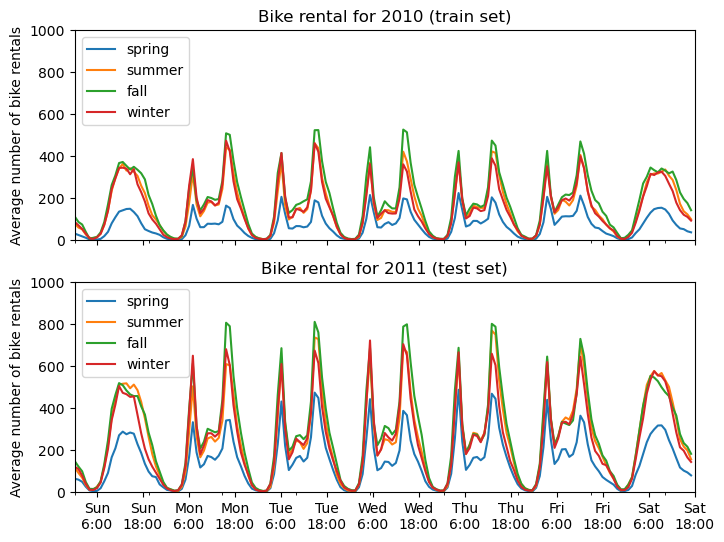

In [15]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

days = ("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")
hours = tuple(range(24))
xticklabels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
xtick_start, xtick_period = 6, 12

fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)
average_bike_rentals = bikes.frame.groupby(
    ["year", "season", "weekday", "hour"], observed=True
).mean(numeric_only=True)["count"]
for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")):
    df.groupby("season", observed=True).plot(ax=ax, legend=True)

    # decorate the plot
    ax.set_xticks(
        np.linspace(
            start=xtick_start,
            stop=len(xticklabels),
            num=len(xticklabels) // xtick_period,
        )
    )
    ax.set_xticklabels(xticklabels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("Average number of bike rentals")
    ax.set_title(
        f"Bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}"
    )
    ax.set_ylim(0, 1_000)
    ax.set_xlim(0, len(xticklabels))
    ax.legend(loc=2)

The first striking difference between the train and test set is that the number of
bike rentals is higher in the test set. For this reason, it will not be surprising to
get a machine learning model that underestimates the number of bike rentals. We
also observe that the number of bike rentals is lower during the spring season. In
addition, we see that during working days, there is a specific pattern around 6-7
am and 5-6 pm with some peaks of bike rentals. We can keep in mind these different
insights and use them to understand the partial dependence plot.




### Preprocessor for the gradient boosting model

For the gradient boosting model, we encode the categorical features using a
:class:`~sklearn.preprocessing.OrdinalEncoder`.



In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

## 1-way partial dependence with different models

In this section, we will compute 1-way partial dependence for  a
gradient-boosting model. With these two models, we illustrate how to compute and
interpret both partial dependence plot (PDP) for both numerical and categorical
features and individual conditional expectation (ICE).




In [17]:
from time import time

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import HistGradientBoostingRegressor

#define a pipeline incorporating the preprocessor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=0,
        max_iter=50,
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.750s
Test R2 score: 0.44


Here, we used the default hyperparameters for the gradient boosting model
without any preprocessing as tree-based models are naturally robust to
monotonic transformations of numerical features.

Note that on this tabular dataset, Gradient Boosting Machines are both
significantly faster to train and more accurate than neural networks. 

We will plot the partial dependence for some of the numerical and categorical
features.



Computing partial dependence plots...
Computing partial dependence plots...
done in 3.224s


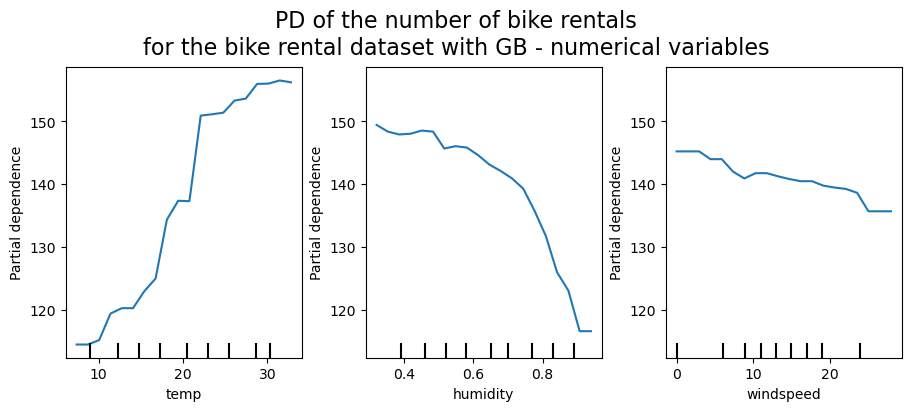

In [18]:
import matplotlib.pyplot as plt

from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}




print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(9, 4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "PD of the number of bike rentals\n"
        "for the bike rental dataset with GB - numerical variables"
    ),
    fontsize=16,
)

Computing partial dependence plots...
Computing partial dependence plots...
done in 0.642s


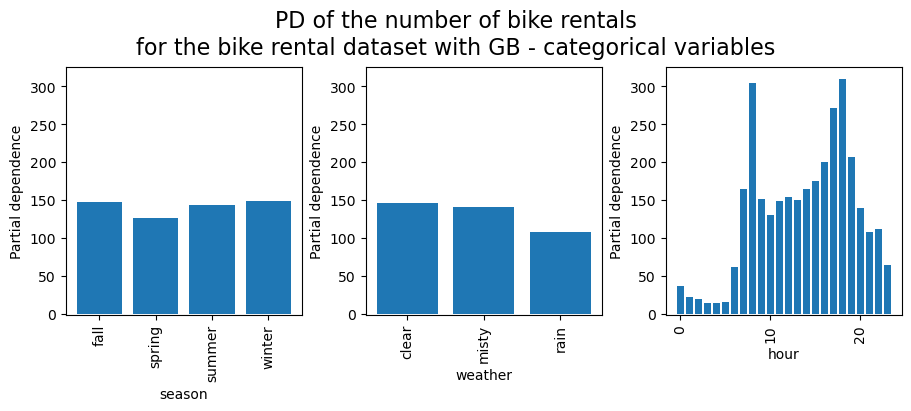

In [19]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}




print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(9, 4), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    (
        "PD of the number of bike rentals\n"
        "for the bike rental dataset with GB - categorical variables"
    ),
    fontsize=16,
)



### Analysis of the plots

We will first look at the PDPs for the numerical features. The
general trend of the PDP of the temperature is that the number of bike rentals is
increasing with temperature. We can make a similar analysis but with the opposite
trend for the humidity features. The number of bike rentals is decreasing when the
humidity increases. Finally, we see the same trend for the wind speed feature. The
number of bike rentals is decreasing when the wind speed is increasing for both
models.

Now, we will look at the partial dependence plots for the categorical features.

We observe that the spring season is the lowest bar for the season feature. With the
weather feature, the rain category is the lowest bar. Regarding the hour feature,
we see two peaks around the 7 am and 6 pm. 

However, it is worth noting that we are creating potential meaningless
synthetic samples if features are correlated.

### ICE vs. PDP
PDP is an average of the marginal effects of the features. We are averaging the
response of all samples of the provided set. Thus, some effects could be hidden. In
this regard, it is possible to plot each individual response. This representation is
called the Individual Effect Plot (ICE). In the plot below, we plot 50 randomly
selected ICEs for the temperature and humidity features.



Computing partial dependence plots and individual conditional expectation...
done in 0.593s


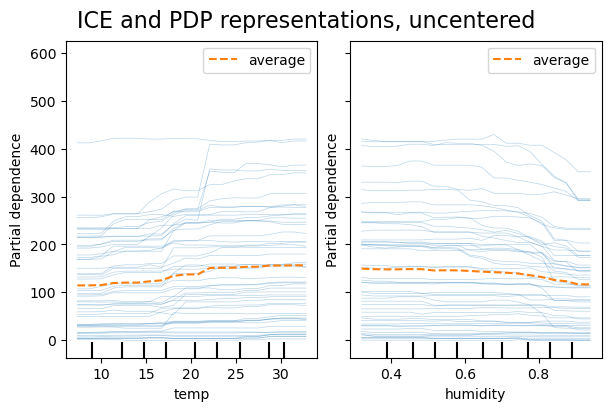

In [20]:
print("Computing partial dependence plots and individual conditional expectation...")
tic = time()
_, ax = plt.subplots(ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": ["temp", "humidity"],
    "kind": "both",
    "centered": False,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations, uncentered", fontsize=16)

Computing partial dependence plots and individual conditional expectation...
done in 0.702s


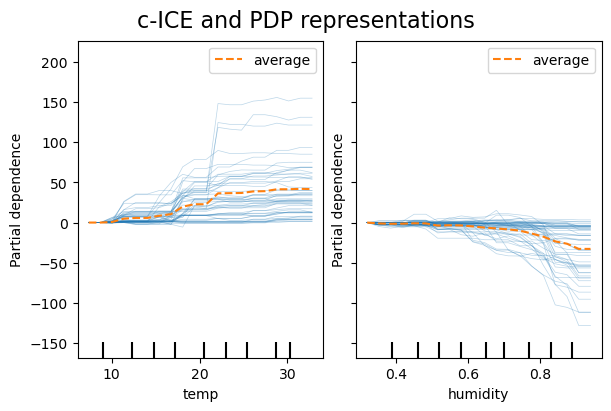

In [21]:
print("Computing partial dependence plots and individual conditional expectation...")
tic = time()
_, ax = plt.subplots(ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)

features_info = {
    "features": ["temp", "humidity"],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle("c-ICE and PDP representations", fontsize=16)

We see that the ICE for the temperature feature gives us some additional information:
Some of the ICE lines are flat while some others show a decrease of the dependence
for temperature above 35 degrees Celsius. We observe a similar pattern for the
humidity feature: some of the ICEs lines show a sharp decrease when the humidity is
above 80%.

Not all ICE lines are parallel, this indicates that the model finds
interactions between features. We can repeat the experiment by constraining the
gradient boosting model to not use any interactions between features using the
parameter `interaction_cst`:



In [22]:
from sklearn.base import clone

interaction_cst = [[i] for i in range(X_train.shape[1])]
hgbdt_model_without_interactions = (
    clone(hgbdt_model)
    .set_params(histgradientboostingregressor__interaction_cst=interaction_cst)
    .fit(X_train, y_train)
)
print(f"Test R2 score: {hgbdt_model_without_interactions.score(X_test, y_test):.2f}")

Test R2 score: 0.20


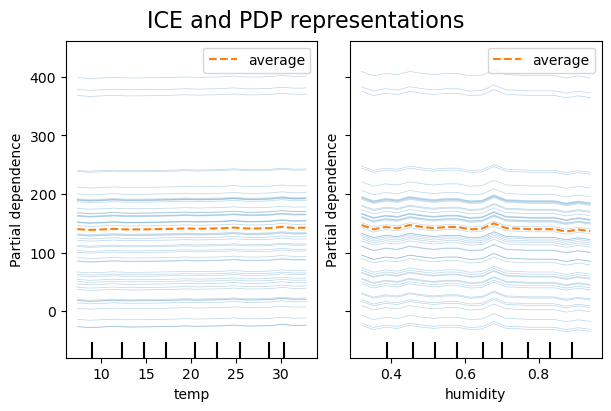

In [23]:
_, ax = plt.subplots(ncols=2, figsize=(6, 4), sharey=True, constrained_layout=True)

features_info["centered"] = False
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model_without_interactions,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)

## 2D interaction plots

PDPs with two features of interest enable us to visualize interactions among them.
However, ICEs cannot be plotted in an easy manner and thus interpreted. We will show
the representation of available in
:meth:`~sklearn.inspection.PartialDependenceDisplay.from_estimator` that is a 2D
heatmap.



Computing partial dependence plots...
done in 7.308s


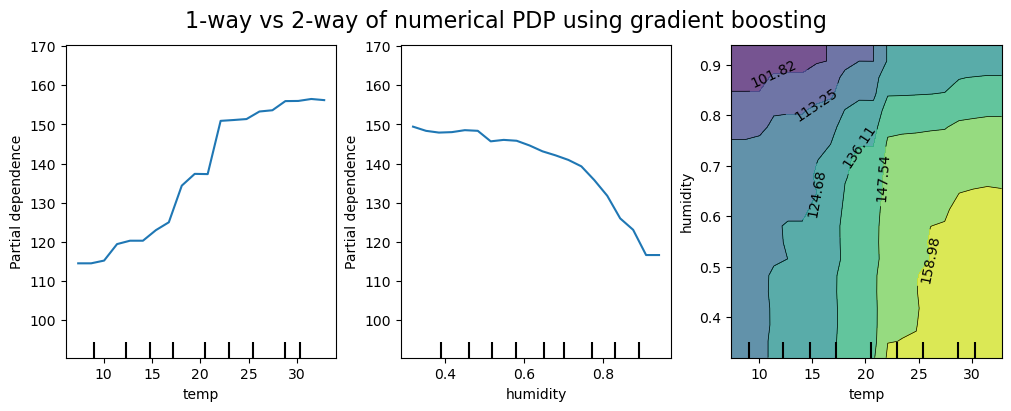

In [24]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", ("temp", "humidity")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16
)

The two-way partial dependence plot shows the dependence of the number of bike rentals
on joint values of temperature and humidity.
We clearly see an interaction between the two features. For a temperature higher than
20 degrees Celsius, the humidity has a impact on the number of bike rentals
that seems independent on the temperature.

On the other hand, for temperatures lower than 20 degrees Celsius, both the
temperature and humidity continuously impact the number of bike rentals.

Furthermore, the slope of the of the impact ridge of the 20 degrees Celsius
threshold is very dependent on the humidity level: the ridge is steep under
dry conditions but much smoother under wetter conditions above 70% of humidity.





The partial dependence between categorical features will provide a discrete
representation that can be shown as a heatmap. For instance the interaction between
the season, the weather, and the target would be as follow:



Computing partial dependence plots...
done in 0.425s


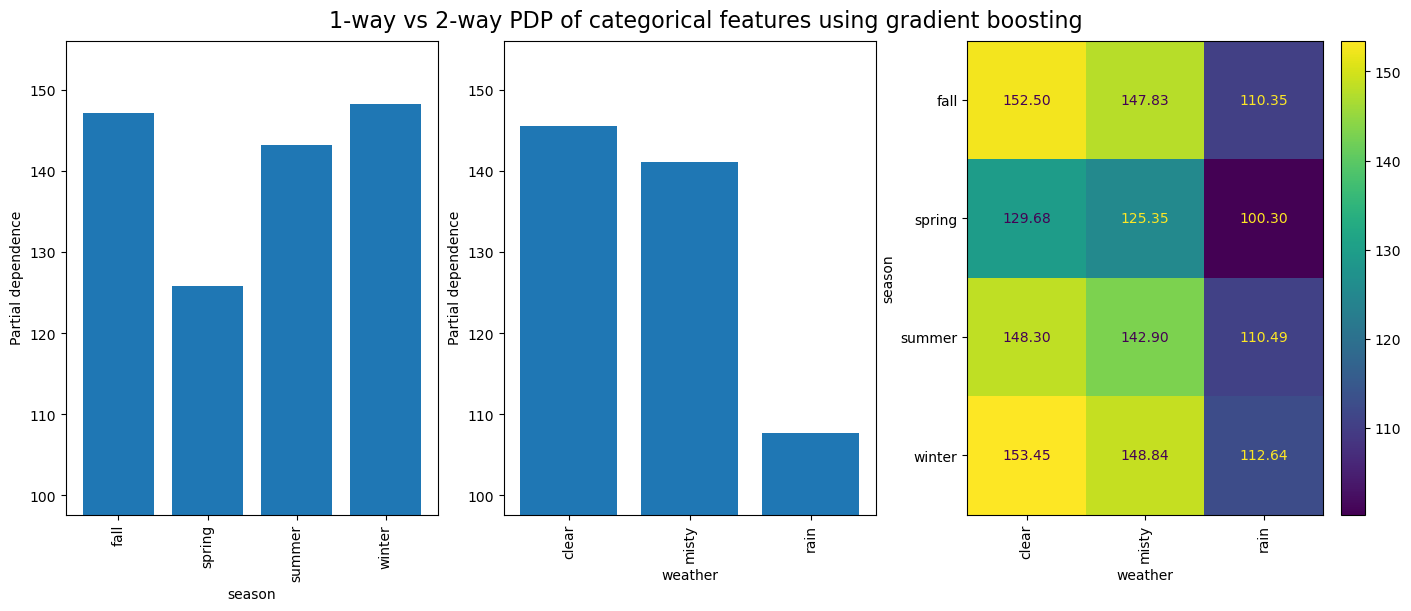

In [26]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["season", "weather", ("season", "weather")],
    "kind": "average",
    "categorical_features": categorical_features,
}
_, ax = plt.subplots(ncols=3, figsize=(14, 6), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way PDP of categorical features using gradient boosting", fontsize=16
)

### 3D representation

Let's make the same partial dependence plot for the 2 features interaction,
this time in 3 dimensions.



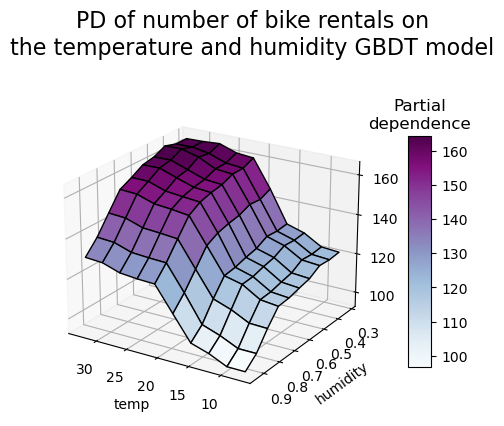

In [27]:
import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np

from sklearn.inspection import partial_dependence

fig = plt.figure(figsize=(5.5, 5))

features = ("temp", "humidity")
pdp = partial_dependence(
    hgbdt_model, X_train, features=features, kind="average", grid_resolution=10
)
XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
Z = pdp.average[0].T
ax = fig.add_subplot(projection="3d")
fig.add_axes(ax)

surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
fig.suptitle(
    "PD of number of bike rentals on\nthe temperature and humidity GBDT model",
    fontsize=16,
)
# pretty init view
ax.view_init(elev=22, azim=122)
clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
clb.ax.set_title("Partial\ndependence")
plt.show()